In [1]:
## Evaluation of two models by cases.

## Need three images in a row

## [baseline pred], [Our pred], [gt]

In [2]:
import os, gc, torch
import os 

import numpy as np
import pandas as pd
# from models.load import TrainedModels

from models.load import get_trained_model
from data.datasets import  OurRadiologsitsDataset, collate_fn
from utils.init import reproducibility, clean_memory_get_device
from data.load import get_datasets, get_dataloaders
from data.constants import XAMI_MIMIC_PATH, DEFAULT_REFLACX_LABEL_COLS
import PIL
from matplotlib.figure import Figure
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm import trange

from typing import Callable, Dict, List, Union, Tuple
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from matplotlib import colors
from utils.pred import pred_thrs_check
from data.datasets import ReflacxDataset, collate_fn
from utils.plot import DISEASE_CMAP, get_legend_elements
from models.train import TrainingInfo


## Suppress the assignement warning from pandas.
pd.options.mode.chained_assignment = None  # default='warn

## Supress user warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

%matplotlib inline
# plt.ioff()

c:\Users\mike8\Desktop\multimodal-abnormalities-detection\models\detectors\rcnn.py:96: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (


In [3]:
use_iobb = True
io_type_str = "IoBB" if use_iobb else "IoU"
labels_cols = DEFAULT_REFLACX_LABEL_COLS
iou_thrs = np.array([0.5])

In [4]:
device = clean_memory_get_device()
reproducibility()

This notebook will running on device: [CUDA]


In [5]:
from enum import Enum

class TrainedModels(Enum):
    CXR_Clinial_fusion1_fusion2="val_ar_0_5436_ap_0_1911_test_ar_0_5476_ap_0_3168_epoch49_WithClincal_05-23-2022 12-06-22_CXR_Clinical_roi_heads_spatialisation"
    CXR_Clinical_fusion1 = "val_ar_0_5476_ap_0_1984_test_ar_0_6038_ap_0_2757_epoch41_WithClincal_05-30-2022 08-01-54_CXR_Clinical_fusion1"
    CXR_Clinical_fusion2= "val_ar_0_4369_ap_0_2098_test_ar_0_4940_ap_0_2218_epoch58_WithClincal_05-30-2022 13-58-43_CXR_Clinical_fusion2"
    CXR="val_ar_0_5659_ap_0_1741_test_ar_0_5390_ap_0_1961_epoch36_WithoutClincal_05-29-2022 12-29-51_CXR"

In [6]:
naming_map = {
    TrainedModels.CXR: "Mask R-CNN (Baseline)",
    TrainedModels.CXR_Clinical_fusion1: "MSF-Net (3D)",
    TrainedModels.CXR_Clinical_fusion2: "MSF-Net (1D)",
    TrainedModels.CXR_Clinial_fusion1_fusion2: "MDF-Net"
}


In [7]:
xami_model, xami_train_info, _, _ = get_trained_model(
    TrainedModels.CXR_Clinial_fusion1_fusion2,
    DEFAULT_REFLACX_LABEL_COLS,
    device,
    rpn_nms_thresh=0.3,
    box_detections_per_img=10,
    box_nms_thresh=0.2,
    rpn_score_thresh=0.0,
    box_score_thresh=0.05,
)
xami_model.to(device)
xami_model.eval()

Load custom model
Using pretrained backbone. mobilenet_v3
Using pretrained backbone. mobilenet_v3
Using SGD as optimizer with lr=0.001


MultimodalMaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): Sequential(
    (0): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
    

In [8]:
baseline_model, baseline_train_info, _, _ = get_trained_model(
    TrainedModels.CXR,
    DEFAULT_REFLACX_LABEL_COLS,
    device,
    rpn_nms_thresh=0.3,
    box_detections_per_img=10,
    box_nms_thresh=0.2,
    rpn_score_thresh=0.0,
    box_score_thresh=0.05,
)
baseline_model.to(device)
baseline_model.eval()

Load custom model
Using pretrained backbone. mobilenet_v3
Mask Hidden Layers 256
Using SGD as optimizer with lr=0.001


MultimodalMaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): Sequential(
    (0): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
    

In [9]:
model_setup = xami_train_info.model_setup

dataset_params_dict = {
        "XAMI_MIMIC_PATH": XAMI_MIMIC_PATH,
        "with_clinical": model_setup.use_clinical,
        "dataset_mode": "normal",
        "bbox_to_mask": model_setup.use_mask,
        "normalise_clinical_num": model_setup.normalise_clinical_num,
        "labels_cols": labels_cols,
    }
    
detect_eval_dataset, train_dataset, val_dataset, test_dataset = get_datasets(
    dataset_params_dict=dataset_params_dict,
)

train_dataloader, val_dataloader, test_dataloader = get_dataloaders(
    train_dataset, val_dataset, test_dataset, batch_size=4,
)

legend_elements = get_legend_elements(DISEASE_CMAP["solid"])

In [10]:
def get_scale(X, feature_range):
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (feature_range[1] - feature_range[0]) + feature_range[0]
    return X_scaled

In [11]:
def get_clinical_3d_img(clinical_expanded_input):

    clinical_3d_np = clinical_expanded_input.squeeze().permute(1, 2, 0).detach().cpu().numpy()
    clinical_3d_minmaxed = get_scale(clinical_3d_np, [0, 1])
    clinical_3d_minmaxed_uint = (clinical_3d_minmaxed*255).astype(np.uint8)
    clinical_3d_img = PIL.Image.fromarray(clinical_3d_minmaxed_uint, 'RGB')

    return clinical_3d_img 

In [12]:
def plot_both_model_bb_for_dataset_idx(
    baseline_model: nn.Module,
    xami_model: nn.Module,
    train_info: TrainingInfo,
    dataset: ReflacxDataset,
    device: str,
    idx: int,
    legend_elements: List[Line2D],
    disease_cmap=DISEASE_CMAP,
    score_thres: Dict = None,
    across_class_nms_thresh = None,
    nms_thresh_in_class = None,
    roi_head_thrs=None,
    plot_gt=False,
    plot_clinical=False,
    plot_original=False,
) -> Tuple[Figure, Union[Figure, None]]:
    # change all the model to eval mode.

    ## retrieve the data, and transform them into input.
    # this dataset has to be the one with clinical.
    data = collate_fn([dataset[idx]])
    data = dataset.prepare_input_from_data(data, device)
    imgs, clinical_num, clinical_cat, targets = data

    clinical_series = dataset.df.iloc[idx][dataset.clinical_cols]
    clinical_series["gender"] = dataset.encoders_map["gender"].inverse_transform(
        [clinical_series["gender"]]
    )[0]

    ## prepare both models for predictions
    baseline_model.eval()
    xami_model.eval()
    if roi_head_thrs:
        baseline_model.roi_heads.score_thresh = roi_head_thrs
        xami_model.roi_heads.score_thresh = roi_head_thrs

    baseline_model.roi_heads.across_class_nms_thresh = across_class_nms_thresh
    xami_model.roi_heads.across_class_nms_thresh = across_class_nms_thresh

    if nms_thresh_in_class:
        baseline_model.roi_heads.nms_thresh = nms_thresh_in_class
        xami_model.roi_heads.nms_thresh = nms_thresh_in_class


    ## perform predictions for both models.
    _, xami_pred = xami_model(imgs, clinical_num, clinical_cat)
    _, baseline_pred = baseline_model(imgs)

    if score_thres:
        xami_pred = [pred_thrs_check(xami_pred[0], dataset, score_thres, device)]
        baseline_pred = [pred_thrs_check(baseline_pred[0], dataset, score_thres, device)]

    bb_fig = plot_bbox_for_model(
        idx=idx,
        clinical_series=clinical_series,
        target=targets[0],
        xami_pred=xami_pred[0],
        baseline_pred=baseline_pred[0], 
        label_idx_to_disease=dataset.label_idx_to_disease,
        legend_elements=legend_elements,
        disease_color_code_map=disease_cmap["solid"],
        plot_clinical=plot_clinical,
        plot_gt=plot_gt,
        plot_original=plot_original,
    )

    return bb_fig


def plot_bbox_for_model(
    idx: int,
    clinical_series: pd.Series,
    target: List[Dict],
    xami_pred: Dict,
    baseline_pred: Dict,
    label_idx_to_disease: Callable[[int], str],
    legend_elements: List[Line2D],
    disease_color_code_map: Dict[str, str],
    plot_original=False,
    plot_clinical:bool = False,
    plot_gt: bool = False,
) -> Figure:
    # clinical + original image + preds
    xami_num_bboxes = len(xami_pred["boxes"])
    baseline_num_bboxes = len(baseline_pred["boxes"])

    slot_size = 2
    task_idx = 0

    if plot_original:
        slot_size += 1

    if plot_gt:
        slot_size += 1

    if plot_clinical:
        slot_size += 1

    # prepare the figure
    fig, axes = plt.subplots(
        1, slot_size, figsize=(slot_size * 10, 10), dpi=120, sharex=True
    )
    img_path = target["image_path"]
    dicom_id = os.path.basename(img_path).split(".")[0]
    fig.suptitle(f"{dicom_id} ({idx})")
    fig.legend(handles=legend_elements, loc="upper right")
    img = PIL.Image.open(target["image_path"]).convert("RGB")

    # show the image in every matrix except the clinical.

    ## take the order. it should be [clinical data, 3d clinical image, original image, other predictions...]

    for ax in axes[(1 if plot_clinical else 0):]:
        ax.imshow(img)

    if plot_clinical:
        # we plot the tabular data in the first axis.
        axes[task_idx].set_title(f"Clinical Data")
        table = axes[task_idx].table(
            cellText=[[v] for v in clinical_series.values],
            rowLabels=clinical_series.index,
            loc="center right",
            colWidths=[0.1, 0.1],
        )
        table.scale(2, 4)
        table.set_fontsize(85)
        axes[task_idx].axis("off")
        # axes[task_idx].axis("tight")

        task_idx +=1

    if plot_original:
        axes[task_idx].set_title(f"Original CXR")
        task_idx += 1

    # plot gt.
    if plot_gt:
        axes[task_idx].set_title(
            f"Ground Truth ({len(target['boxes'].detach().cpu().numpy())})"
        )

        for label, bbox in zip(
            target["labels"].detach().cpu().numpy(),
            target["boxes"].detach().cpu().numpy(),
        ):
            disease = label_idx_to_disease(label)
            c = disease_color_code_map[disease]
            axes[task_idx].add_patch(
                Rectangle(
                    (bbox[0], bbox[1]),
                    bbox[2] - bbox[0],
                    bbox[3] - bbox[1],
                    fill=False,
                    color=c,
                    linewidth=2,
                )
            )
            axes[task_idx].text(
                bbox[0], bbox[1], disease, color="black", backgroundcolor=c
            )
        task_idx += 1
        
    # plot baseline predictions.
    axes[task_idx].set_title(f"CXR (Baseline) Predictions ({baseline_num_bboxes})")
    for i, (label, bbox, score) in enumerate(
        zip(
            baseline_pred["labels"].detach().cpu().numpy(),
            baseline_pred["boxes"].detach().cpu().numpy(),
            baseline_pred["scores"].detach().cpu().numpy(),
        )
    ):
        ax = axes[task_idx]
        disease = label_idx_to_disease(label)
        c = disease_color_code_map[disease]

        # for the predictions. generate the recs, and draw it on fig.
        ax.add_patch(
            Rectangle(
                (bbox[0], bbox[1]),
                bbox[2] - bbox[0],
                bbox[3] - bbox[1],
                fill=False,
                color=c,
                linewidth=2,
            )
        )
        ax.text(
            bbox[0],
            bbox[1],
            f"{disease} ({score:.2f})",
            color="black",
            backgroundcolor=c,
        )

    task_idx += 1
        

    # plot mimic predictions
    axes[task_idx].set_title(f"CXR+Clinical (1D+3D) Predictions ({xami_num_bboxes})")
    for i, (label, bbox, score) in enumerate(
            zip(
                xami_pred["labels"].detach().cpu().numpy(),
                xami_pred["boxes"].detach().cpu().numpy(),
                xami_pred["scores"].detach().cpu().numpy(),
            )
        ):
            ax = axes[task_idx]
            disease = label_idx_to_disease(label)
            c = disease_color_code_map[disease]

            # for the predictions. generate the recs, and draw it on fig.
            ax.add_patch(
                Rectangle(
                    (bbox[0], bbox[1]),
                    bbox[2] - bbox[0],
                    bbox[3] - bbox[1],
                    fill=False,
                    color=c,
                    linewidth=2,
                )
            )
            ax.text(
                bbox[0],
                bbox[1],
                f"{disease} ({score:.2f})",
                color="black",
                backgroundcolor=c,
            )

    return fig

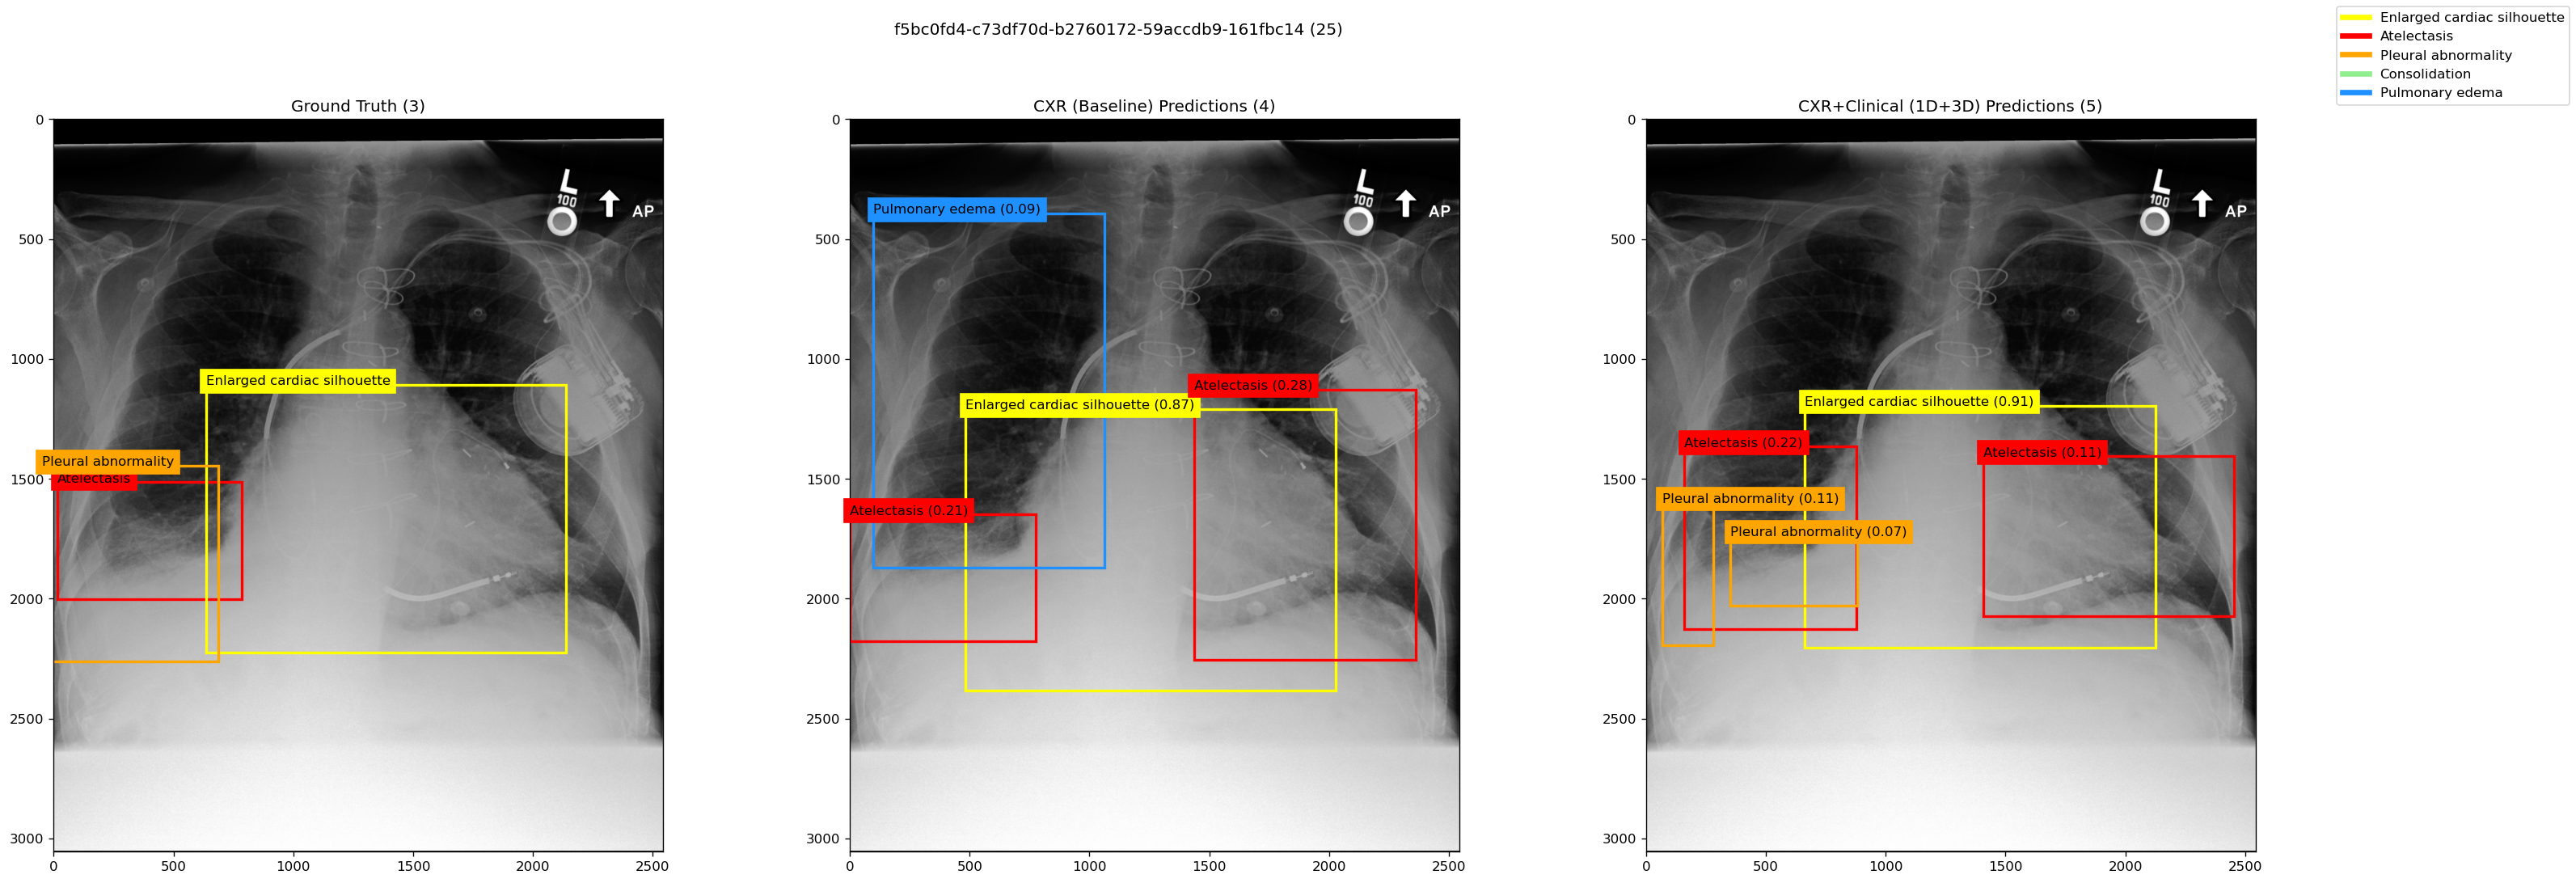

In [13]:
# for generating the example in the paper.

iou_thrs = 0.05
# score_thres = {
#     "Enlarged cardiac silhouette": 0.5,
#     "Atelectasis": 0.2,
#     "Pleural abnormality": 0.1,
#     "Consolidation": 0.1,
#     "Pulmonary edema": 0.1,
# }
score_thres = None
fig = plot_both_model_bb_for_dataset_idx(
    baseline_model=baseline_model,
    xami_model=xami_model,
    train_info=xami_train_info,
    dataset=detect_eval_dataset,
    device=device,
    idx=25,
    legend_elements=legend_elements,
    disease_cmap=DISEASE_CMAP,
    score_thres=score_thres,
    roi_head_thrs=iou_thrs,
    plot_gt=True,
    plot_clinical=False,
    across_class_nms_thresh= 0.8,
    nms_thresh_in_class=1e-2,
)



In [14]:
# saving_folder_name = "evalute_both_models_by_case_nms"

# for iou_thrs in [
#     # 0.05,
#     # 0.1,
#     0.3
# ]:
#     ### modify the naming here.
#     destination_folder = os.path.join(
#         saving_folder_name, f"generated_bb (thrs={iou_thrs}) gt & 3-D clinical"
#     )
#     os.makedirs(saving_folder_name, exist_ok=True)
#     os.makedirs(destination_folder, exist_ok=True)
#     os.makedirs(os.path.join(destination_folder, "train"), exist_ok=True)
#     os.makedirs(os.path.join(destination_folder, "val"), exist_ok=True)
#     os.makedirs(os.path.join(destination_folder, "test"), exist_ok=True)

#     for dataset_type in ["train", "val", "test"]:
#         df = detect_eval_dataset.df
#         commenting_df = pd.DataFrame(df[df["split"] == dataset_type]["dicom_id"])
#         max_box_num = 10
#         for i in range(1, max_box_num + 1):
#             commenting_df[f"Bounding Box {i}"] = [""] * len(commenting_df)

#         commenting_df[
#             [f"Bounding Box {i}" for i in range(1, max_box_num + 1)] + ["dicom_id"]
#         ].to_csv(
#             os.path.join(
#                 destination_folder, dataset_type, f"{dataset_type}_commenting.csv"
#             ),
#             index_label="ID",
#         )

#     for idx in trange(0, len(detect_eval_dataset)):
#         fig = plot_both_model_bb_for_dataset_idx(
#             baseline_model=baseline_model,
#             xami_model=xami_model,
#             train_info=xami_train_info,
#             dataset=detect_eval_dataset,
#             device=device,
#             idx=idx,
#             legend_elements=legend_elements,
#             disease_cmap=DISEASE_CMAP,
#             score_thres=None,
#             roi_head_thrs=iou_thrs,
#             plot_gt=True,
#             plot_clinical=False,
#             across_class_nms_thresh= 0.9,
#             nms_thresh_in_class=1e-2,
#         )

#         instance = detect_eval_dataset.df.iloc[idx]
#         fig.savefig(
#             os.path.join(
#                 destination_folder,
#                 instance["split"],
#                 f"({idx}) {instance['dicom_id']}.png",
#             )
#         )
#         plt.cla()
#         plt.clf()
#         plt.close("all")
